### Data Inspection and Cleaning

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import pyarrow.parquet as pq

parquet = pq.read_table('taxi_data.parquet')
df = parquet.to_pandas()

display(df.head(), df.shape, df.size)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


(2964624, 19)

56327856

In [3]:
# Examine structure and cardinality of each column

for col in df.columns:
    print('\n', col)
    print(len(df[col].unique()))
    if len(df[col].unique()) < 15:
        print(df[col].unique())


 VendorID
3
[2 1 6]

 tpep_pickup_datetime
1575706

 tpep_dropoff_datetime
1574780

 passenger_count
11
[ 1.  2.  0.  4.  3.  5.  6.  8.  7.  9. nan]

 trip_distance
4489

 RatecodeID
8
[ 1.  5.  2.  4. 99.  3.  6. nan]

 store_and_fwd_flag
3
['N' 'Y' None]

 PULocationID
260

 DOLocationID
261

 payment_type
5
[2 1 4 3 0]

 fare_amount
8970

 extra
48

 mta_tax
8
[ 0.5  0.  -0.5  1.6  0.8  4.   1.4  3. ]

 tip_amount
4192

 tolls_amount
1127

 improvement_surcharge
5
[ 1.  -1.   0.   0.3 -0.3]

 total_amount
19241

 congestion_surcharge
7
[ 2.5   0.   -2.5   0.75  1.   -0.75   nan]

 Airport_fee
4
[ 0.    1.75 -1.75   nan]


In [4]:
# The TLC's data dictionary explains that the binary VendorID attribute indicates the TPEP (Taxicab Passenger Enhancement Program) data provider responsible for the record.
# Although this information could plausibly be used for e.g., quality assurance purposes internally, it appeared deeply uninteresting and will therefore be dropped.
# The same reasoning applies to the binary store_and_fwd_flag, which indicates whether or not the data were initially stored locally and later sent to the data vendors.

df.drop(columns=['VendorID','store_and_fwd_flag'], inplace=True)

#### Drop Erroneous Datetime Entries

In [5]:
# In subsequent data cleaning and loading steps it became clear that, bizarrely, this January 2024 dataset appears to contain tpep_pickup_dateime and tpep_dropoff_datetime
# entries corresponding to other years (viz. 2023, 2009, and 2002). Clearly 2002 and 2009 entries should be dropped, but 2023 entries may be 'carryovers' from December 31st 
# pickups, necessitating additional data inspection and cleaning

# Incorrect years

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

print('YEARS')

display(df['tpep_pickup_datetime'].dt.year.unique(), df['tpep_dropoff_datetime'].dt.year.unique())

print('Erroneous pickup years:', len(df['tpep_pickup_datetime'][df['tpep_pickup_datetime'].dt.year.isin([2002,2009])]))
print('Erroneous dropoff years', len(df['tpep_dropoff_datetime'][df['tpep_dropoff_datetime'].dt.year.isin([2002,2009, 2023])]))

to_drop = df['tpep_pickup_datetime'].dt.year.isin([2002,2009]) | df['tpep_dropoff_datetime'].dt.year.isin([2002,2009, 2023])
df = df.loc[~to_drop]

# Incorrect months

print('\nMONTHS')

display(df['tpep_pickup_datetime'].dt.month.unique(), df['tpep_dropoff_datetime'].dt.month.unique())

print('Erroneous pickup month:', len(df['tpep_pickup_datetime'][df['tpep_pickup_datetime'].dt.month.isin([2])]))
print('Erroneous dropoff month:', len(df['tpep_dropoff_datetime'][df['tpep_dropoff_datetime'].dt.month.isin([12])]))

to_drop = df['tpep_pickup_datetime'].dt.month.isin([2]) | df['tpep_dropoff_datetime'].dt.month.isin([12])
df = df.loc[~to_drop]

# Finally, since the erroneous date 2024-02-02 persisted following the above prune, it took some additional digging to discover that one cab ride starting on 1/31 was recorded
# as over 24 hours in duration from 01-31 pickup to 02-02 dropoff

from datetime import date
print('\n>50+ hour cab ride:')
display(df[df['tpep_pickup_datetime'].dt.date == date(2024, 2, 2)], df[df['tpep_dropoff_datetime'].dt.date == date(2024, 2, 2)])

YEARS


array([2024, 2023, 2009, 2002], dtype=int32)

array([2024, 2023, 2009, 2002], dtype=int32)

Erroneous pickup years: 5
Erroneous dropoff years 8

MONTHS


array([ 1, 12,  2], dtype=int32)

array([1, 2], dtype=int32)

Erroneous pickup month: 3
Erroneous dropoff month: 0

>50+ hour cab ride:


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2758973,2024-01-31 12:39:24,2024-02-02 13:56:52,1.0,0.0,1.0,207,260,2,3.0,0.0,0.5,0.0,0.0,1.0,4.5,0.0,0.0


#### Examine and Drop NaN

tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64

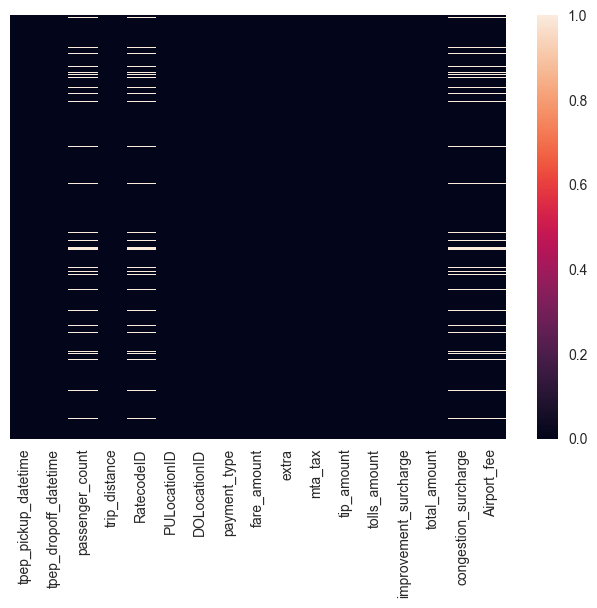

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2824462,2024-01-01 00:34:19,2024-01-01 00:51:22,NaN,2.04,NaN,143,141,0,12.72,0.00,0.5,0.00,0.00,1.0,16.72,NaN,NaN
2824463,2024-01-01 00:14:31,2024-01-01 00:19:29,NaN,1.60,NaN,236,238,0,9.30,1.00,0.5,2.86,0.00,1.0,17.16,NaN,NaN
2824464,2024-01-01 00:35:11,2024-01-01 01:13:40,NaN,0.00,NaN,142,79,0,21.01,0.00,0.5,0.00,0.00,1.0,25.01,NaN,NaN
2824465,2024-01-01 00:33:37,2024-01-01 00:50:34,NaN,0.00,NaN,237,4,0,17.79,0.00,0.5,0.00,0.00,1.0,21.79,NaN,NaN
2824466,2024-01-01 00:49:04,2024-01-01 01:01:16,NaN,0.00,NaN,244,50,0,34.65,0.00,0.5,0.00,0.00,1.0,38.65,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


Percentage of data remaining after dropna(): 0.952721653720064


In [6]:
# Get a sense for how much missing data exists in our df, and what proportion of data would be lost were it to be excluded from the pipeline and analysis

display(df.isna().sum())

sns.heatmap(df.isna().reset_index(drop=True).sample(1000), yticklabels=False)
plt.show()

display(df[df.isna().any(axis=1)])

print('Percentage of data remaining after dropna():', df.dropna().shape[0] / df.shape[0])

# Since over 95% of the data is retained after exluding np.nan, we will proceed by simply omitting missing values (although it may be interesting to analyze the original df  
# for potential correlations between other attributes and missing data to see whether, e.g., time of day or store_and_fwd_flag are associated with missing data values).

df.dropna(inplace=True)

### Schema Implementation

#### Date Dimension Table

In [17]:
dates = pd.concat([df['tpep_pickup_datetime'].dt.date, df['tpep_dropoff_datetime'].dt.date]).sort_values().drop_duplicates()

dim_date = pd.DataFrame({
    'date_id':range(1,len(dates)+1), 
    'date':pd.to_datetime(dates) # Convert to datetime for more time-efficient month, day, etc. extraction
    })

dim_date['year'] = dim_date['date'].dt.year.astype(int)
dim_date['month'] = dim_date['date'].dt.month.astype(int)
dim_date['day'] = dim_date['date'].dt.day.astype(int)
dim_date['day_of_week'] = dim_date['date'].dt.day_of_week.astype(int)
dim_date['is_weekend'] = dim_date['day_of_week'].apply(lambda d: 1 if d in [5,6] else 0).astype(int)
dim_date['date'] = dim_date['date'].dt.date # Convert back to date

display(dim_date.head())

,date_id,date,year,month,day,day_of_week,is_weekend
4142,1,2023-12-31,2023,12,31,6,1
6373,2,2024-01-01,2024,1,1,0,0
93273,3,2024-01-02,2024,1,2,1,0
209140,4,2024-01-03,2024,1,3,2,0
230550,5,2024-01-04,2024,1,4,3,0


#### Time Dimension Table

In [11]:
times = pd.concat([df['tpep_pickup_datetime'].dt.time, df['tpep_dropoff_datetime'].dt.time]).sort_values().drop_duplicates()

dim_time = pd.DataFrame({
    'time_id':range(1,len(times)+1), 
    'time':pd.to_datetime(times, format='%H:%M:%S') # Convert to datetime for more time-efficient hour, minute, etc. extraction
    })

dim_time['hour'] = dim_time['time'].dt.hour
dim_time['minute'] = dim_time['time'].dt.minute
dim_time['second'] = dim_time['time'].dt.second
dim_time['time'] = dim_time['time'].dt.time # Convert back to time

display(dim_time.head())

,time_id,time,hour,minute,second
1196108,1,00:00:00,0,0,0
2454423,2,00:00:01,0,0,1
2463029,3,00:00:02,0,0,2
1791662,4,00:00:03,0,0,3
1867330,5,00:00:04,0,0,4


#### Location Dimension Table

In [10]:
# The location information encoded in the PULocationID and DOLocationID columns is provided by the NYC TLC in .csv form alongside their data dictionary as the 
# Taxi Zone Lookup Table at https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

dim_location = pd.read_csv('taxi_zone_lookup.csv')

dim_location.columns = ['location_id', 'borough', 'zone', 'service_zone']

dim_location

,location_id,borough,zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


#### Rate and Payment Dimension Tables

In [13]:
# The rate and payment type code dictionaries defined below were obtained via information in the TLC's data dictionary 
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf 

rate_code_lib = {1:'Standard Rate', 2:'JFK', 3:'Newark', 4:'Nassau or Westchester', 5:'Negotiated fare', 6:'Group ride', 99:'Unknown'}

dim_rate_code = pd.DataFrame({
    'rate_code_id':rate_code_lib.keys(), 
    'rate_code':rate_code_lib.values()
    })

payment_type_lib = {1:'Credit card', 2:'Cash', 3:'No charge', 4:'Dispute', 5:'Unkown', 6:'Voided trip'}

dim_payment_type = pd.DataFrame({
    'payment_type_id':payment_type_lib.keys(), 
    'payment_type':payment_type_lib.values()
    })

display(dim_rate_code, dim_payment_type)

,rate_code_id,rate_code
0,1,Standard Rate
1,2,JFK
2,3,Newark
3,4,Nassau or Westchester
4,5,Negotiated fare
5,6,Group ride
6,99,Unknown


,payment_type_id,payment_type
0,1,Credit card
1,2,Cash
2,3,No charge
3,4,Dispute
4,5,Unkown
5,6,Voided trip


#### Fact Table

In [27]:
fact_table = pd.DataFrame()

fact_table['pickup_date_id'] = df['tpep_pickup_datetime'].dt.date.map(dim_date.reset_index().set_index('date')['date_id'])
fact_table['dropoff_date_id'] = df['tpep_dropoff_datetime'].dt.date.map(dim_date.reset_index().set_index('date')['date_id'])
fact_table['pickup_time_id'] = df['tpep_pickup_datetime'].dt.time.map(dim_time.reset_index().set_index('time')['time_id'])
fact_table['dropoff_time_id'] = df['tpep_dropoff_datetime'].dt.time.map(dim_time.reset_index().set_index('time')['time_id'])
fact_table['pickup_location_id'] = df['PULocationID'].astype(int)
fact_table['dropoff_location_id'] = df['DOLocationID'].astype(int)
fact_table['payment_type_id'] = df['payment_type']
fact_table['rate_code_id'] = df['RatecodeID']
fact_table['airport_fee'] = df['Airport_fee']
fact_table['passenger_count'] = df['passenger_count'].astype(int)
other_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']
fact_table[other_cols] = df[other_cols]

fact_table.index.name = 'fact_id'
                
display(fact_table.head())

display(df.head(), df.shape, fact_table.shape)



,pickup_date_id,dropoff_date_id,pickup_time_id,dropoff_time_id,pickup_location_id,dropoff_location_id,payment_type_id,rate_code_id,airport_fee,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
fact_id,,,,,,,,,,,,,,,,,,,
0,2,2,3476,4664,186,79,2,1.0,0.0,1,1.72,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5
1,2,2,181,577,140,236,1,1.0,0.0,1,1.80,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5
2,2,2,1027,2102,236,79,1,1.0,0.0,1,4.70,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5
3,2,2,2199,2697,79,211,1,1.0,0.0,1,1.40,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5
4,2,2,2812,3178,211,148,1,1.0,0.0,1,0.80,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


(2824451, 19)

(2824451, 19)